In [1]:
import numpy as np
import pandas as pd

import utils
from sklearn.metrics.pairwise import paired_distances
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn

from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn.preprocessing import StandardScaler, scale
from scipy.spatial import distance

from einops import rearrange, reduce, repeat


In [3]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [4]:
subjs = utils.ExpInfo.getSubjIDs()
task = utils.ExpInfo.taskName[0]


In [54]:
subj = subjs[46]
# iTrial = 0
wSize = 60


df_beh = utils.LoadData.behaviorData(subj, task)
_, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
_, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
dist_measure = 'euclidean'

# dist_timeSeries = []
# v_timeSeries = []
d = []
for iTrial in range(len(h)):
    h_trial = h[iTrial][:-1, :]
    h_disp_trial = h_disp[iTrial]

    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp_dot = np.diff(h_disp_trial, axis=0)

    dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
    v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
    
    # d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
    #           'dist_sd': -dist_timeSeries_.std(),
    #           'v_mean': 1-v_timeSeries_.mean(),
    #           'v_sd': -v_timeSeries_.std()})
    d.append({'dist_mean': -dist_timeSeries_.mean(), 
              'dist_sd': -dist_timeSeries_.std(),
              'v_mean': -v_timeSeries_.mean(),
              'v_sd': -v_timeSeries_.std()})    
    # v_timeSeries.append(v_timeSeries_)
    
    
    

# dist_timeSeries = np.vstack(dist_timeSeries).T
# v_timeSeries = np.vstack(v_timeSeries).T
print(df_beh.iloc[iTrial])

    

participant       Reg-S-4
trial no.              60
actual control        0.3
angular bias           90
response                1
group                   S
Name: 59, dtype: object


[[0.3684439  1.72996972]] [0.80700691]


<AxesSubplot:xlabel='actual control', ylabel='response_pred'>

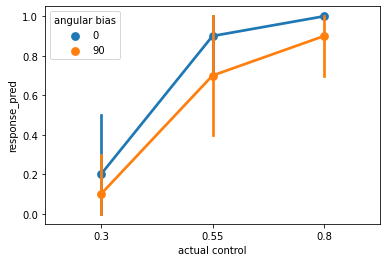

In [55]:
df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
X = df_[['dist_mean']]
X = df_[['v_mean']]
X = df_[['dist_mean', 'v_mean']]
# X = df_[['dist_mean', 'v_mean', 'dist_sd', 'v_sd']]
# X = df_[['dist_mean']]
X = StandardScaler().fit_transform(X)

y = df_['response']
# class_weightdict = {0: 1, 1: 1}
LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
df_['response_pred'] = LR.predict(X)
print(LR.coef_, LR.intercept_)

plt.figure()
sns.pointplot(x='actual control', y='response_pred', hue='angular bias', data=df_)

<AxesSubplot:xlabel='actual control', ylabel='v_sd'>

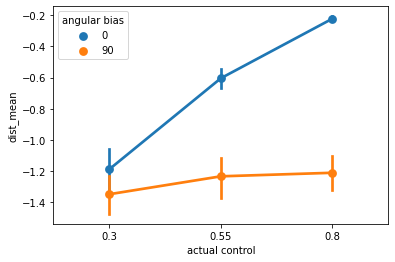

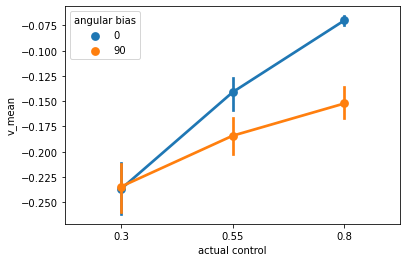

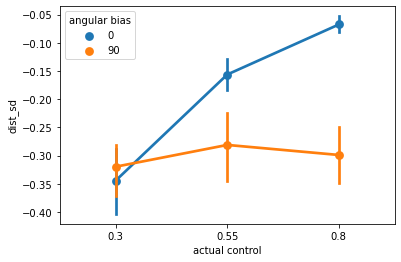

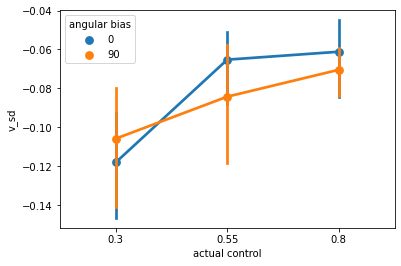

In [56]:
d_ = pd.DataFrame(d)
df_ = pd.concat([df_beh, d_], axis=1)   
# df_['dist_mean']=1-df_['dist_mean']
plt.figure()
sns.pointplot(x='actual control', y='dist_mean', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='v_mean', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='dist_sd', hue='angular bias', data=df_)
plt.figure()
sns.pointplot(x='actual control', y='v_sd', hue='angular bias', data=df_)

In [57]:
# n = 2
# mean = np.zeros(n)
# cov = np.eye(n)
# rv = multivariate_normal(mean=mean, cov=cov)
# samples = rv.rvs(10000)

# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# sns.distplot(dist_sample)
# # plt.plot(samples[:, 0], samples[:, 1], 'o')

In [58]:
def binary_separability_all(h_trial, h_disp_trial):
    """
    Compute the binary separability of the given dataset.
    """

    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp = np.diff(h_disp_trial, axis=0)

    Xs = {}

    X = np.vstack([h_trial, h_disp_trial])
    Xs['p'] = X
    X = np.vstack([vh, vh_disp])
    Xs['v'] = X


    hvh = np.hstack([h_trial[:-1], vh])
    hvh_disp = np.hstack([h_disp_trial[:-1], vh_disp])
    X = np.vstack([hvh, hvh_disp])
    Xs['p+v'] = X


    diff = h_disp_trial - h_trial
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['p_diff'] = X


    diff = vh_disp - vh
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['v_diff'] = X

    diff1 = h_disp_trial - h_trial
    diff2 = vh_disp - vh
    diff = np.hstack([diff1[:-1, :], diff2])
    diff_zero = np.zeros_like(diff)
    X = np.vstack([diff, diff_zero])
    Xs['p_diff+v_diff'] = X

    def binary_separability(X, nRun=10):
        labels = np.tile(np.array([0, 1]), [int(X.shape[0]/2), 1]).flatten(order='F')
        
        acc_run = []
        for iRun in range(nRun):
            # labels_ = KMeans(n_clusters=2, random_state=4).fit_predict(X)
            labels_ = GaussianMixture(n_components=2, random_state=iRun).fit_predict(X)
            
            acc = np.mean(labels_ == labels)
            if acc < 0.5:
                acc = 1-acc
            acc_run.append(acc)
        acc_run = np.array(acc_run).mean()
        return -acc

    for name, X in Xs.items():
        # print(name, binary_separability(X))
        Xs[name] = binary_separability(X)
    return Xs

# binary_separability_all(h_trial, h_disp_trial)

In [59]:
# subj = subjs[5]
# iTrial = 0
wSize = 60


df_beh = utils.LoadData.behaviorData(subj, task)
_, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
_, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
dist_measure = 'euclidean'

# dist_timeSeries = []
# v_timeSeries = []
d = []
bs = []
for iTrial in range(len(h)):
    h_trial = h[iTrial][:-1, :]
    h_disp_trial = h_disp[iTrial]

    # hidden action plan velocity
    vh = np.diff(h_trial, axis=0)
    vh_disp_dot = np.diff(h_disp_trial, axis=0)

    dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
    v_timeSeries_ = paired_distances(vh, vh_disp_dot, metric=dist_measure)
    
    d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
              'dist_sd': -dist_timeSeries_.std(),
              'v_mean': 1-v_timeSeries_.mean(),
              'v_sd': -v_timeSeries_.std()})
    
    
    
    bs.append(binary_separability_all(h_trial, h_disp_trial))


/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sk

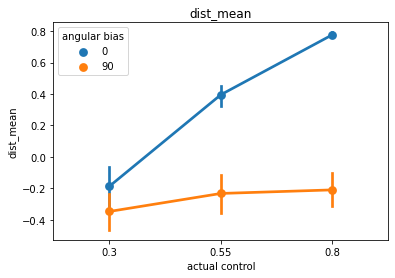

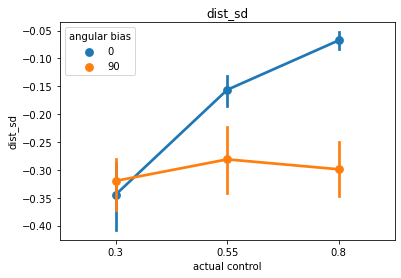

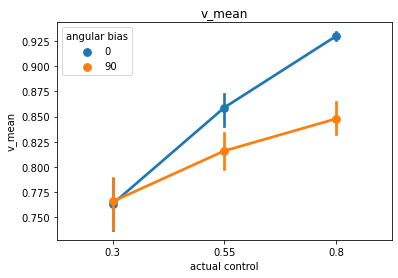

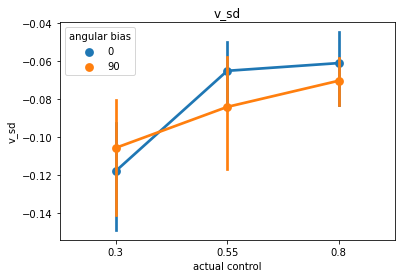

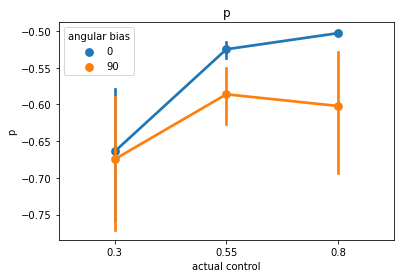

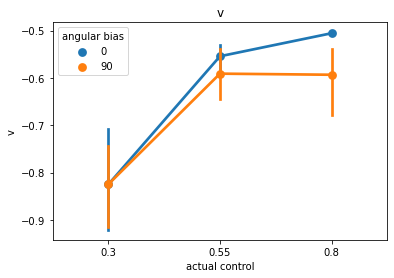

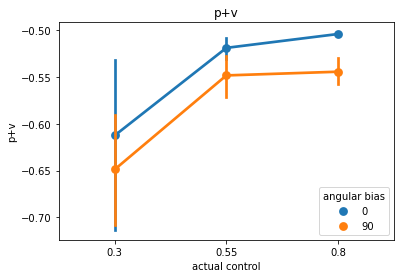

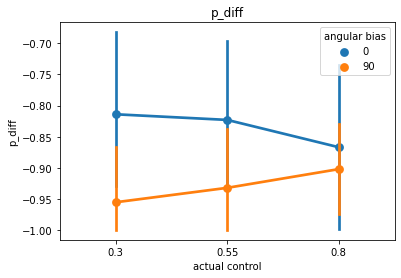

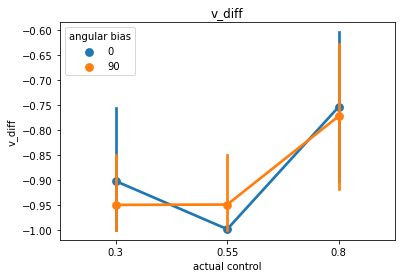

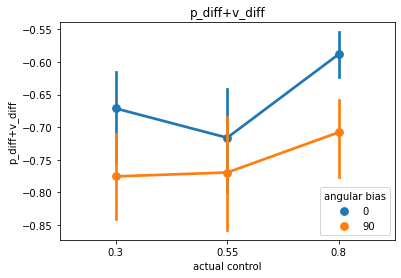

In [60]:
df_ = pd.concat([df_beh, pd.DataFrame(d), pd.DataFrame(bs)], axis=1)
columns = df_.loc[:, 'dist_mean':].columns.values
for column in columns:
    plt.figure()
    sns.pointplot(x='actual control', y=column, hue='angular bias', data=df_)
    plt.title(column)


[[-0.31571288  1.25929841  0.5593103 ]] [0.38493997]


<AxesSubplot:xlabel='actual control', ylabel='response_pred'>

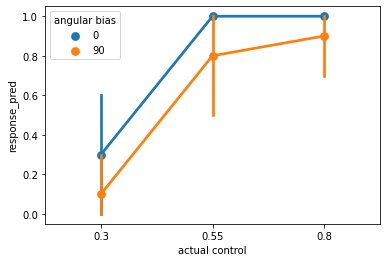

In [86]:
# df_ = pd.concat([df_beh, pd.DataFrame(d)], axis=1)
# X = df_[['p']]
# X = df_[['v']]
# X = df_[['p', 'v']]
# X = df_[['p+v']]
X = df_[['p', 'v', 'p+v']]
# X = df_[['p_diff', 'v_diff']]
X = StandardScaler().fit_transform(X)

y = df_['response']
LR = LogisticRegression(fit_intercept=True, class_weight='balanced').fit(X, y)
df_['response_pred'] = LR.predict(X)
print(LR.coef_, LR.intercept_)

plt.figure()
sns.pointplot(x='actual control', y='response_pred', hue='angular bias', data=df_)

# By trial

In [62]:
# subj = subjs[10]
# # iTrial = 0
# wSize = 60


# df_beh = utils.LoadData.behaviorData(subj, task)
# _, h, _ = utils.LoadData.xhy(subj, task, wSize=wSize)
# _, h_disp, _ = utils.LoadData.xhy_disp(subj, task, wSize=wSize)
# dist_measure = 'euclidean'


In [63]:
# iTrial = 5
# h_trial = h[iTrial][:-1, :]
# h_disp_trial = h_disp[iTrial]

# # hidden action plan velocity
# vh = np.diff(h_trial, axis=0)
# vh_disp = np.diff(h_disp_trial, axis=0)

# dist_timeSeries_ = paired_distances(h_trial, h_disp_trial, metric=dist_measure)
# v_timeSeries_ = paired_distances(vh, vh_disp, metric=dist_measure)

# # d.append({'dist_mean': 1-dist_timeSeries_.mean(), 
# #             'dist_sd': -dist_timeSeries_.std(),
# #             'v_mean': 1-v_timeSeries_.mean(),
# #             'v_sd': -v_timeSeries_.std()})


    

In [64]:
# print(df_beh.iloc[iTrial])


In [65]:
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture
# Xs = {}

# X = np.vstack([h_trial, h_disp_trial])
# Xs['position'] = X
# X = np.vstack([vh, vh_disp])
# Xs['velocity'] = X


# hvh = np.hstack([h_trial[:-1], vh])
# hvh_disp = np.hstack([h_disp_trial[:-1], vh_disp])
# X = np.vstack([hvh, hvh_disp])
# Xs['p+v'] = X


# diff = h_disp_trial - h_trial
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['p_diff'] = X


# diff = vh_disp - vh
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['v_diff'] = X

# diff1 = h_disp_trial - h_trial
# diff2 = vh_disp - vh
# diff = np.hstack([diff1[:-1, :], diff2])
# diff_zero = np.zeros_like(diff)
# X = np.vstack([diff, diff_zero])
# Xs['p_diff+v_diff'] = X

# def binary_separability(X, nRun=10):
#     labels = np.tile(np.array([0, 1]), [int(X.shape[0]/2), 1]).flatten(order='F')
    
#     acc_run = []
#     for iRun in range(nRun):
#         # labels_ = KMeans(n_clusters=2, random_state=4).fit_predict(X)
#         labels_ = GaussianMixture(n_components=2, random_state=0).fit_predict(X)
        
#         acc = np.mean(labels_ == labels)
#         if acc < 0.5:
#             acc = 1-acc
#         acc_run.append(acc)
#     acc_run = np.array(acc_run).mean()
#     return acc

# for name, X in Xs.items():
#     print(name, binary_separability(X))


In [66]:


# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dist_timeSeries_)
# ax.set_ylim([0, 2])
# plt.title('position dist')



# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(v_timeSeries_)
# ax.set_ylim([0, 2])
# plt.title('v dist')


# # intention traj diff

# dd = utils.DataProcessing.diff(h_trial)
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dd)
# ax.set_ylim([0, 2])
# plt.title('intention t t+1')

# dd = utils.DataProcessing.diff(h_disp_trial)
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.plot(dd)
# ax.set_ylim([0, 2])
# plt.title('disp t t+1')

In [67]:
# diff = h_disp_trial - h_trial
# mean = np.mean(diff, axis=0)
# cov = np.cov(diff, rowvar=0)

# from scipy.stats import multivariate_normal
# rv = multivariate_normal(mean=mean, cov=cov)
# nSample = 10000
# samples = rv.rvs(nSample)

In [68]:
# from scipy.spatial import distance
# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# # dist_sample = paired_distances(np.tile(mean, (nSample, 1)), samples, metric='euclidean')
# dist_target = distance.cdist(np.expand_dims(mean, 0), np.zeros((1, diff.shape[1])), 'euclidean')

In [69]:
# plt.plot(dist_sample)
# plt.plot(dist_target, 'or')

In [70]:
# n = 2
# mean = np.zeros(n)
# cov = np.eye(n)
# rv = multivariate_normal(mean=mean, cov=cov)
# samples = rv.rvs(10000)

# dist_sample = distance.cdist(np.expand_dims(mean, 0), samples, 'euclidean').flatten()
# sns.distplot(dist_sample)
# # plt.plot(samples[:, 0], samples[:, 1], 'o')